In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint as pp
import seaborn as sns
from itertools import chain
from collections import Counter
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [2]:
headers = ['url', 'price', 'partial_title', 'geo_lat', 'geo_long', 'rating',
           'number_reviews', 'sleeps', 'bedrooms', 'bathrooms', 'min_stay',
           'has_elevator', 'has_concierge', 'has_patio', 'has_pool', 'floor_area',
           'title', 'description', 'distance_to_TS_meter', 'distance_to_TS']

data_file = 'data/homeaway_rentals_nyc_PARSED.csv' 
df = pd.read_csv(data_file, sep='\t', header=0, names=headers, index_col=0)
df[['description']] = df[['description']].fillna(value='')

# Try modeling only with nightly prices under $1000
# df = df.loc[df.price < 1000].reset_index()

In [3]:
# do some feature engineering
df['text_clean'] = df['title'].map(str) + ' ' + df["description"]
df['text_clean'] = df['text_clean'].str.replace(r'[:\*,\.]', '')
df['text_clean'] = df['text_clean'].str.strip()

df['text_twenty_four'] = df['text_clean'].str.contains(" 24/7 ")
df['text_master'] = df['text_clean'].str.contains(" master ")
df['text_requests'] = df['text_clean'].str.contains(" requests ")
df['text_advance'] = df['text_clean'].str.contains(" advance ")

In [4]:
# Look at text in expensive houses
df_expensive = df.loc[df.price > 300].reset_index()
print(df_expensive.shape)

text_words = df_expensive['text_clean'].as_matrix()
all_words = list(chain.from_iterable([str(rental_text).split(' ') for rental_text in text_words]))
counts = Counter(all_words)
# counts.most_common()[25:]

# finest: 440, cleaning: 458
# doorman: 244, marble: 260, luxury: 344, luxurious: 164, 
# linens: 450, requests: 450, 24/7: 433, master: 432, advance: 431
# df[df['text_clean'].str.contains("advance")].text_clean

(1286, 26)


In [5]:
# Look at text in cheap houses

df_regular = df.loc[df.price <= 300].reset_index()

print(df_regular.shape)
text_words = df_regular['text_clean'].as_matrix()
all_words = list(chain.from_iterable([str(rental_text).split(' ') for rental_text in text_words]))
counts = Counter(all_words)
# counts.most_common()[25:]
# cleaning: 326

# doorman: 355, marble: 189, luxury: 457, luxurious: 150, 
# linens: 641, requests: 152, 24/7: 185, advance: 127, master: 225

(2211, 26)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3497 entries, 0 to 5330
Data columns (total 25 columns):
url                     3497 non-null object
price                   3497 non-null int64
partial_title           3497 non-null object
geo_lat                 3497 non-null float64
geo_long                3497 non-null float64
rating                  3497 non-null float64
number_reviews          3497 non-null int64
sleeps                  3497 non-null int64
bedrooms                3497 non-null int64
bathrooms               3497 non-null int64
min_stay                3497 non-null float64
has_elevator            3497 non-null bool
has_concierge           3497 non-null bool
has_patio               3497 non-null bool
has_pool                3497 non-null bool
floor_area              3497 non-null float64
title                   3497 non-null object
description             3497 non-null object
distance_to_TS_meter    3497 non-null int64
distance_to_TS          3497 non-null float64
t

In [7]:
# # Not all rentals have reviews
# df_with_reviews = df[df.rating.notnull()]

# # Plot some basic graphs to understand the data
# fig_overview, ax_overview = plt.subplots(2, 2, figsize=(15, 15))

# ax_overview[0][0].hist(df.bedrooms.as_matrix())
# ax_overview[0][0].set_title('Distribution of Bedroom Count')
# ax_overview[0][0].set_xlabel('# Bedrooms')
# ax_overview[0][0].set_ylabel('Frequency')

# ax_overview[0][1].hist(df_with_reviews.rating.as_matrix())
# ax_overview[0][1].set_title('Distribution of Ratings')
# ax_overview[0][1].set_xlabel('Rating')
# ax_overview[0][1].set_ylabel('Frequency')
# ax_overview[0][1].xaxis.set_ticks(np.arange(1,5,1))

# ax_overview[1][0].hist(df.price.as_matrix())
# ax_overview[1][0].set_title('Distribution of Nightly Rental Prices')
# ax_overview[1][0].set_xlabel('Rental Price per Night')
# ax_overview[1][0].set_ylabel('Frequency')

# ax_overview[1][1].hist(df.distance_to_TS.as_matrix())
# ax_overview[1][1].set_title('Distribution of Driving Distance to Times Square')
# ax_overview[1][1].set_xlabel('Driving distance to Time Square (m)')
# ax_overview[1][1].set_ylabel('Frequency')

In [8]:
df.describe()

,price,geo_lat,geo_long,rating,number_reviews,sleeps,bedrooms,bathrooms,min_stay,floor_area,distance_to_TS_meter,distance_to_TS
count,3497.000000,3497.000000,3497.000000,3497.000000,3497.000000,3497.000000,3497.000000,3497.000000,3497.000000,3497.000000,3497.000000,3497.000000
mean,319.792108,40.742996,-73.973735,4.710323,6.587075,4.525593,1.654561,1.240778,9.682013,864.889477,7954.964255,4.942984
std,268.607730,0.045415,0.047548,0.403474,16.424867,1.816996,0.925532,0.521084,12.170184,457.563265,6625.457281,4.116867
min,19.000000,40.571015,-74.257572,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,51.000000,0.031690
25%,160.000000,40.718319,-73.993633,4.800000,0.000000,3.000000,1.000000,1.000000,2.000000,650.000000,2827.000000,1.756616
50%,247.000000,40.745160,-73.980212,4.800000,0.000000,4.000000,2.000000,1.000000,3.000000,750.000000,5602.000000,3.480920
75%,387.000000,40.767068,-73.952842,4.800000,4.000000,6.000000,2.000000,1.000000,13.000000,900.000000,11429.000000,7.101649
max,2688.000000,40.974511,-73.712820,5.000000,175.000000,9.000000,6.000000,6.000000,90.000000,5000.000000,32177.000000,19.993855


In [9]:
# Get a sense for how features correlate with price
features_all = ['rating', 'number_reviews', 'sleeps', 'bedrooms', 'bathrooms', 'min_stay',
               'has_elevator', 'has_concierge', 'has_patio', 'has_pool', 'floor_area',
               'distance_to_TS', 'text_twenty_four', 'text_master', 'text_requests', 'text_advance']
X = df.loc[:, features_all]
y = df['price']

# Split the data 70-30 train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

df.corr()['price'][['price'] + features_all].sort_values()

distance_to_TS     -0.271942
min_stay           -0.155797
number_reviews     -0.090902
has_pool            0.016306
has_concierge       0.045147
rating              0.093836
has_patio           0.112906
has_elevator        0.137751
text_twenty_four    0.297355
text_requests       0.308426
text_master         0.351936
sleeps              0.365958
text_advance        0.366461
floor_area          0.377540
bedrooms            0.431163
bathrooms           0.515595
price               1.000000
Name: price, dtype: float64

In [10]:
# Get a sense for how features correlate with each other
# X.corr()

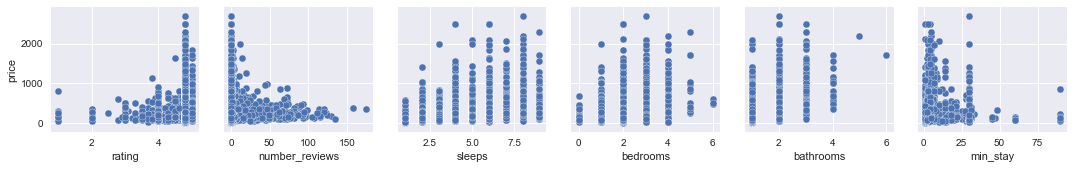

In [11]:
sns.pairplot(data=df, y_vars=['price'], x_vars=features_all[0:6])

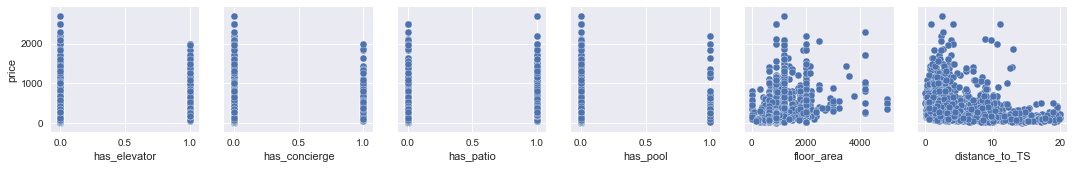

In [12]:
sns.pairplot(data=df, y_vars=['price'], x_vars=features_all[6:12])

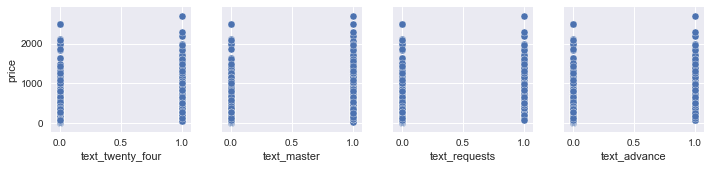

In [13]:
sns.pairplot(data=df, y_vars=['price'], x_vars=features_all[12:])

## Multiple Linear Regression with # Bedrooms and Distance from Times Square

In [14]:
# Helper functions
def print_error(title, y_test, y_predict_test):
    print ('Errors for ', title, ':')
    print ("RMSE:", np.sqrt(mean_squared_error(y_test, y_predict_test)))
    print ("MAE:", mean_absolute_error(y_test, y_predict_test))
    print ("R2:", r2_score(y_test, y_predict_test))
    
def order_zip_coeff(coeff_names, coeff_vals):
    coeff_names = np.array(coeff_names)
    coeff_vals = np.array(coeff_vals)
    importance_indices = np.argsort(coeff_vals)[::-1]
    return list(zip(coeff_names[importance_indices], coeff_vals[importance_indices]))

In [15]:
features_2 = ['bedrooms', 'distance_to_TS']
lr_model2 = LinearRegression()
lr_model2.fit(X_train.loc[:, features_2], y_train)
order_zip_coeff(features_2, lr_model2.coef_)

[('bedrooms', 136.66737298536449), ('distance_to_TS', -21.258784143929994)]

In [16]:
y_test_pred2 = lr_model2.predict(X_test.loc[:, features_2])
print_error('Multiple Linear Regression with 2 variables', y_test, y_test_pred2)

Errors for  Multiple Linear Regression with 2 variables :
RMSE: 216.335909717
MAE: 136.537117007
R2: 0.287450620517


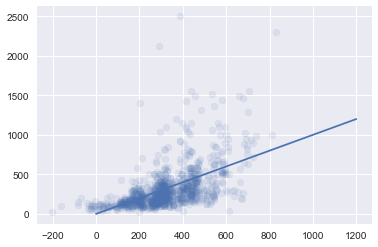

In [17]:
## Plot predicted price vs actual price
plt.scatter(y_test_pred2, y_test, alpha=.1)
plt.plot(np.linspace(0, 1200, 10), np.linspace(0, 1200, 10))

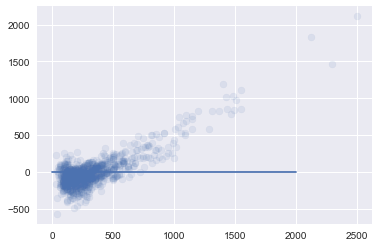

In [18]:
## Residual Plot
plt.scatter(y_test, y_test - y_test_pred2, alpha=.1)
plt.plot(np.linspace(0, 2000, 10), np.linspace(0, 0, 10))

## Multiple Linear Regression with 4 variables

In [19]:
features_4 = ['bedrooms', 'bathrooms',
              'min_stay', 'distance_to_TS']
lr_model_4 = LinearRegression()
lr_model_4.fit(X_train.loc[:, features_4], y_train)
order_zip_coeff(features_4, lr_model_4.coef_)

[('bathrooms', 193.07803271628234),
 ('bedrooms', 75.737122664197756),
 ('min_stay', -4.3082183885305483),
 ('distance_to_TS', -22.442080905806492)]

In [20]:
y_test_pred4 = lr_model_4.predict(X_test.loc[:, features_4])
print_error('Multiple Linear Regression with 4 variables', y_test, y_test_pred4)

Errors for  Multiple Linear Regression with 4 variables :
RMSE: 192.062503925
MAE: 117.335042708
R2: 0.438379553092


## Multiple Linear Regression with all variables

In [34]:
X = df.loc[:, features_all]
lr_model_all = LinearRegression()
lr_model_all.fit(X_train.loc[:, features_all], y_train)
order_zip_coeff(features_all, lr_model_all.coef_)

[('text_advance', 144.74339328015765),
 ('bathrooms', 130.57871454729175),
 ('text_master', 78.127889323807409),
 ('bedrooms', 41.743500685080122),
 ('rating', 41.131557142208763),
 ('text_requests', 39.353988226120393),
 ('text_twenty_four', 34.158938802147759),
 ('has_concierge', 18.851327972598867),
 ('has_elevator', 17.086774993792687),
 ('has_pool', 16.046748974671985),
 ('sleeps', 12.466750225784812),
 ('has_patio', 12.022709503438037),
 ('floor_area', 0.039789375741190014),
 ('number_reviews', -1.2804832156249764),
 ('min_stay', -4.7370894299918724),
 ('distance_to_TS', -20.697917880052643)]

In [23]:
y_test_pred_all = lr_model_all.predict(X_test.loc[:, features_all])
print_error('Multiple Linear Regression with all variables', y_test, y_test_pred_all)

Errors for  Multiple Linear Regression with all variables :
RMSE: 183.530695849
MAE: 111.249624212
R2: 0.487167948603


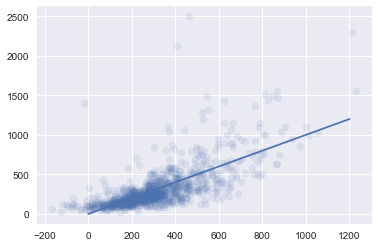

In [24]:
## Plot predicted price vs actual price
plt.scatter(y_test_pred_all, y_test, alpha=.1)
plt.plot(np.linspace(0, 1200, 10), np.linspace(0, 1200, 10))

## Lasso Regression

In [25]:
alphavec = 10**np.linspace(-5,9,1000)
lasso_model = LassoCV(alphas = alphavec, cv=5, selection='random')
lasso_model.fit(X_train.loc[:, features_all], y_train)
lasso_model.alpha_

0.11221477682079803

In [26]:
order_zip_coeff(features_all, lasso_model.coef_)

[('text_advance', 143.82355735436224),
 ('bathrooms', 130.50751810583807),
 ('text_master', 77.795814676022502),
 ('bedrooms', 41.473069272981384),
 ('rating', 40.505934107767779),
 ('text_requests', 39.403396407076549),
 ('text_twenty_four', 33.840968495429422),
 ('has_concierge', 18.119489152080149),
 ('has_elevator', 16.931527887199199),
 ('has_pool', 14.465162740899258),
 ('sleeps', 12.47106861739621),
 ('has_patio', 11.236490028274497),
 ('floor_area', 0.040543091833661914),
 ('number_reviews', -1.279037863736697),
 ('min_stay', -4.7289730147149607),
 ('distance_to_TS', -20.710158231275702)]

In [ ]:
y_test_pred_lasso = lasso_model.predict(X_test)
print_error('Lasso Regression', y_test, y_test_pred_lasso)

## Simple Decision Tree

In [27]:
features_all_tree = np.array(['number_reviews', 'sleeps', 'bedrooms', 'bathrooms', 'min_stay',
                   'has_elevator', 'has_concierge', 'has_patio', 'has_pool', 'floor_area',
                   'distance_to_TS', 'geo_lat', 'geo_long',
                   'text_twenty_four', 'text_master', 'text_requests', 'text_advance'])
X_tree = df.loc[:, features_all_tree]

# Split the data 70-30 train/test
X_train_tree, X_test_tree, y_train, y_test = train_test_split(X_tree, y, test_size=0.3, random_state=42)

dtrmodel = tree.DecisionTreeRegressor(min_samples_split=10, max_depth=10, min_samples_leaf=8)
dtrmodel.fit(X_train_tree, y_train)
tree.export_graphviz(dtrmodel, out_file='tree.dot', feature_names=X_train_tree.columns)

!head tree.dot

digraph Tree {
node [shape=box] ;
0 [label="bathrooms <= 1.5\nmse = 74853.6712\nsamples = 2447\nvalue = 323.3715"] ;
1 [label="distance_to_TS <= 4.1682\nmse = 29696.0909\nsamples = 1937\nvalue = 259.2142"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="min_stay <= 7.5\nmse = 31992.6267\nsamples = 1086\nvalue = 311.5285"] ;
1 -> 2 ;
3 [label="bedrooms <= 1.5\nmse = 36863.0361\nsamples = 721\nvalue = 359.2441"] ;
2 -> 3 ;
4 [label="floor_area <= 893.5\nmse = 27362.5675\nsamples = 457\nvalue = 304.8403"] ;


In [28]:
y_test_pred_decision = dtrmodel.predict(X_test_tree)
print_error('Simple Decision Tree', y_test, y_test_pred_decision)

Errors for  Simple Decision Tree :
RMSE: 183.159325845
MAE: 102.087840425
R2: 0.489241255785


## Random Forest

In [29]:
lr_model_rf = RandomForestRegressor()
lr_model_rf.fit(X_train_tree.loc[:, features_all_tree], y_train)

order_zip_coeff(features_all_tree, lr_model_rf.feature_importances_)

[('bathrooms', 0.22071474566559121),
 ('distance_to_TS', 0.15807251701991315),
 ('geo_long', 0.14001164896142049),
 ('min_stay', 0.084192055120479781),
 ('text_advance', 0.08268669496360477),
 ('geo_lat', 0.071198110983755808),
 ('floor_area', 0.070383055235087949),
 ('bedrooms', 0.049030104496871174),
 ('sleeps', 0.04616695662521958),
 ('number_reviews', 0.018188787471312112),
 ('text_master', 0.012931611138913394),
 ('has_pool', 0.012265571572185842),
 ('has_patio', 0.0087308403335920361),
 ('has_elevator', 0.0083978751917363238),
 ('has_concierge', 0.0065966532017382659),
 ('text_twenty_four', 0.0063906737719893565),
 ('text_requests', 0.0040420982465887512)]

In [30]:
y_test_pred_rf = lr_model_rf.predict(X_test_tree)
print_error('Random Forest', y_test, y_test_pred_rf)

Errors for  Random Forest :
RMSE: 175.427497902
MAE: 90.3403492946
R2: 0.531453092187


## Gradient Boosted Tree

In [31]:
gbmodel1 = GradientBoostingRegressor(subsample=0.7, learning_rate=0.1, max_depth=4, n_estimators=1000)
gbmodel1.fit(X_train_tree, y_train)

order_zip_coeff(features_all_tree, gbmodel1.feature_importances_)

[('distance_to_TS', 0.22753540523473606),
 ('geo_long', 0.22721458286354596),
 ('geo_lat', 0.20325670978219179),
 ('floor_area', 0.074944962229687009),
 ('min_stay', 0.059301060637706363),
 ('sleeps', 0.048902539296803091),
 ('number_reviews', 0.034945979176117359),
 ('bathrooms', 0.030071967787485551),
 ('bedrooms', 0.021714850435604553),
 ('text_master', 0.014309140427444965),
 ('text_advance', 0.010039599892999847),
 ('has_elevator', 0.0098803930617398159),
 ('has_concierge', 0.0096157250628494065),
 ('text_requests', 0.0074240755785959641),
 ('text_twenty_four', 0.0072080967501303274),
 ('has_pool', 0.0068338574158516591),
 ('has_patio', 0.0068010543665099846)]

In [32]:
y_test_pred_gb1 = gbmodel1.predict(X_test_tree)
print_error('Gradient Boosted Tree', y_test, y_test_pred_gb1)

Errors for  Gradient Boosted Tree :
RMSE: 158.431324071
MAE: 83.6522510537
R2: 0.617844740194


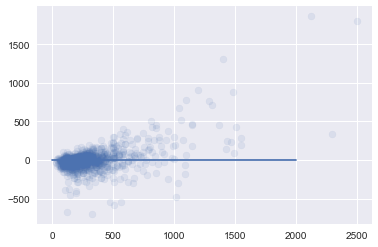

In [33]:
## Residual Plot
plt.scatter(y_test, y_test - y_test_pred_gb1, alpha=.1)
plt.plot(np.linspace(0, 2000, 10), np.linspace(0, 0, 10))